In [17]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [18]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [19]:
# Load labels from the dataset
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [20]:
# Defining a helper function for loading a batch of images
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [21]:
#Defining a function to show the stats for batch ans specific sample
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 6:
Image - Min Value: 30 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


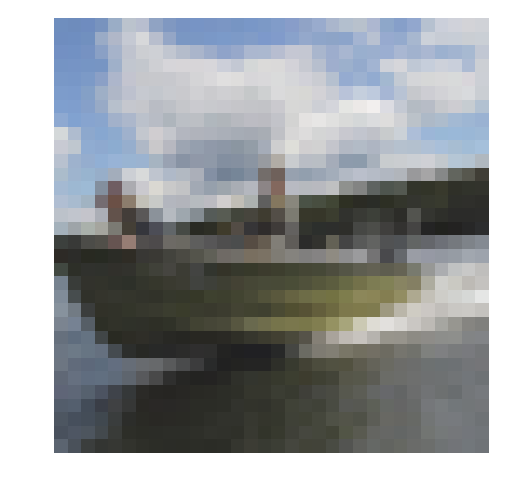

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore a specific batch and sample from the dataset
batch_id = 3
sample_id = 6
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

Apply normalization and 1-hot encoding to dataset


In [23]:
#Function used to normalize CIFAR-10 images to be in the range of [0,1]
def normalize(images):        
    # initial zero ndarray    
    normalized_images = np.zeros_like(images.astype(float))        
    
    # The first images index is number of images where the other indices indicates    
    # hieight, width and depth of the image    
    num_images = images.shape[0]        
    
    # Computing the minimum and maximum value of the input image to do the normalization based on them    
    maximum_value, minimum_value = images.max(), images.min()        
    
    # Normalize all the pixel values of the images to be from 0 to 1    
    for img in range(num_images):        
        normalized_images[img,...] = (images[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)    
    return normalized_images

In [24]:
# encoding the input images. Each image will be represented by a vector of zeros except for the class index of the image 
# that this vector represents. The length of this vector depends on number of classes that we have
# the dataset which is 10 in CIFAR-10

from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(images):        
    num_classes = 10        
    
    #use sklearn helper function of OneHotEncoder() to do that     
    encoder = OneHotEncoder(num_classes)        
    
    #resize the input images to be 2D    
    input_images_resized_to_2d = np.array(images).reshape(-1,1)    
    one_hot_encoded_targets = encoder.fit_transform(input_images_resized_to_2d)
    
    return one_hot_encoded_targets.toarray()

In [25]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

In [26]:
# Call function for preprocessing of the data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [27]:
# Load the Preprocessed Validation data
valid_input_features, valid_input_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

# Model Building


In [28]:
# Defining the model inputs
import tensorflow as tf
def images_input(img_shape): 
    return tf.placeholder(tf.float32, (None, ) + img_shape, name="input_images")

def target_input(num_classes):  
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target") 
    return target_input

#define a function for the dropout layer keep probability
def keep_prob_input(): 
    return tf.placeholder(tf.float32, name="keep_prob")

C:\Users\bhask\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [29]:
# Applying a convolution operation to the input tensor followed by max pooling
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size, pool_layer_strides): 
    input_depth = input_tensor.get_shape()[3].value 
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)   
    
    #Defining layer weights and biases 
    weights = tf.Variable(tf.random_normal(weight_shape)) 
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))  
    
    #Considering the biase variable 
    conv_strides = (1,) + conv_layer_strides + (1,)
    
    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME') 
    conv_layer = tf.nn.bias_add(conv_layer, biases) 
    
    conv_kernel_size = (1,) + conv_kernel_size + (1,) 
    
    pool_strides = (1,) + pool_layer_strides + (1,) 
    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME') 
    
    return pool_layer

In [30]:
#Flatten the output of max pooling layer to be fing to the fully connected layer which only accepts the output
# to be in 2D
def flatten_layer(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)


In [31]:
#Define the fully connected layer that will use the flattened output of the stacked convolution layers
#to do the actuall classification
def fully_connected_layer(input_tensor, num_outputs): 
    return tf.layers.dense(input_tensor, num_outputs)

In [32]:
#Defining the output function
def output_layer(input_tensor, num_outputs):    
    return  tf.layers.dense(input_tensor, num_outputs)

In [33]:
def build_convolution_net(image_data, keep_prob):  
    # Applying 3 convolution layers followed by max pooling layers 
    conv_layer_1 = conv2d_layer(image_data, 32, (3,3), (1,1), (3,3), (3,3))  
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3,3), (1,1), (3,3), (3,3)) 
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3,3), (1,1), (3,3), (3,3))
    
    # Flatten the output from 4D to 2D to be fed to the fully connected layer 
    flatten_output = flatten_layer(conv_layer_3)
    
    # Applying 2 fully connected layers with drop out 
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64) 
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob) 
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32) 
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)  
    
    #Applying the output layer while the output size will be the number of categories that we have 
    #in CIFAR-10 dataset 
    output_logits = output_layer(fully_connected_layer_2, 10)
    
    #returning output 
    return output_logits

In [34]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

In [35]:
#Using the helper function above to build the network
#First off, let's remove all the previous inputs, weights, biases form the previous runs
tf.reset_default_graph()

# Defining the input placeholders to the convolution neural network
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [36]:
test_conv_net(build_convolution_net)

Neural Network Built!


# Training Model

In [37]:
#Define a helper function for kicking off the training process
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):
    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

In [38]:
#Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):        
    validation_loss = session.run(model_cost, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})    
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})        
    
    print("Valid Loss: %f" %(validation_loss))    
    print("Valid accuracy: %f" % (validation_accuracy))

In [39]:
# Model Hyperparameters
num_epochs = 100
batch_size = 128
keep_probability = 0.5

In [40]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [56]:
print('Training on only a Single Batch from the CIFAR-10 Dataset...')
with tf.Session() as sess:  
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    # Training cycle 
    for epoch in range(num_epochs): 
        batch_ind = 1  
        for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
            train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
            
            print('Epoch number {:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

Training on only a Single Batch from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1969.457764
Valid accuracy: 0.148438
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1938.916504
Valid accuracy: 0.117188
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1951.459717
Valid accuracy: 0.140625
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1666.243652
Valid accuracy: 0.195312
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1255.376709
Valid accuracy: 0.156250
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1463.325806
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1370.492432
Valid accuracy: 0.054688
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1103.180176
Valid accuracy: 0.140625
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 941.212646
Valid accuracy: 0.132812
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 907.853882
Valid accuracy: 0.171875
Epoch number  1, CIFAR-10 Batch

Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 161.357758
Valid accuracy: 0.320312
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 196.155579
Valid accuracy: 0.250000
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 171.471619
Valid accuracy: 0.398438
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 144.633118
Valid accuracy: 0.335938
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 121.811562
Valid accuracy: 0.429688
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 119.786453
Valid accuracy: 0.445312
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 145.510727
Valid accuracy: 0.312500
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 100.960136
Valid accuracy: 0.390625
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 149.163132
Valid accuracy: 0.273438
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 128.465775
Valid accuracy: 0.421875
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 127.005478
Valid accuracy: 0.406250
Epoch numb

Valid accuracy: 0.421875
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 56.952682
Valid accuracy: 0.437500
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 64.397491
Valid accuracy: 0.390625
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 64.326546
Valid accuracy: 0.375000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 49.069252
Valid accuracy: 0.492188
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 61.189041
Valid accuracy: 0.375000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 56.387589
Valid accuracy: 0.445312
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 67.561707
Valid accuracy: 0.429688
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 62.303101
Valid accuracy: 0.468750
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 58.435158
Valid accuracy: 0.429688
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 66.814034
Valid accuracy: 0.382812
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 65.852791
Valid accuracy: 0.437

Valid accuracy: 0.468750
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 38.448868
Valid accuracy: 0.429688
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 30.570765
Valid accuracy: 0.476562
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 39.444588
Valid accuracy: 0.382812
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 22.875290
Valid accuracy: 0.554688
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 36.283142
Valid accuracy: 0.484375
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 34.199055
Valid accuracy: 0.421875
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 35.445923
Valid accuracy: 0.414062
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 31.493999
Valid accuracy: 0.460938
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 35.205246
Valid accuracy: 0.453125
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 31.050819
Valid accuracy: 0.445312
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 39.196251
Valid accuracy: 0.359

Valid accuracy: 0.429688
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 21.863543
Valid accuracy: 0.507812
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 26.944824
Valid accuracy: 0.429688
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 21.427492
Valid accuracy: 0.492188
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 22.832172
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 22.106178
Valid accuracy: 0.421875
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 20.345715
Valid accuracy: 0.523438
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 22.016350
Valid accuracy: 0.492188
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 15.509601
Valid accuracy: 0.468750
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 20.599239
Valid accuracy: 0.406250
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 17.225981
Valid accuracy: 0.468750
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 20.106274
Valid accuracy: 0.406

Valid accuracy: 0.507812
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 9.462915
Valid accuracy: 0.484375
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 8.078459
Valid accuracy: 0.460938
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 12.739835
Valid accuracy: 0.460938
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 11.176746
Valid accuracy: 0.484375
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 10.583725
Valid accuracy: 0.429688
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 12.575027
Valid accuracy: 0.406250
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 10.981787
Valid accuracy: 0.500000
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 9.896722
Valid accuracy: 0.484375
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 9.646686
Valid accuracy: 0.539062
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 12.085024
Valid accuracy: 0.515625
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 14.300483
Valid accuracy: 0.398438


Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.851919
Valid accuracy: 0.554688
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 8.073880
Valid accuracy: 0.460938
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.958183
Valid accuracy: 0.453125
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.861326
Valid accuracy: 0.312500
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.328933
Valid accuracy: 0.359375
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.235435
Valid accuracy: 0.468750
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.552703
Valid accuracy: 0.429688
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.487642
Valid accuracy: 0.531250
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.240147
Valid accuracy: 0.406250
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.646914
Valid accuracy: 0.437500
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.236769
Valid accuracy: 0.453125
Epoch number 16, CIFAR-10 Batch 

Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.597862
Valid accuracy: 0.468750
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 1.961060
Valid accuracy: 0.421875
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.696128
Valid accuracy: 0.375000
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.100973
Valid accuracy: 0.414062
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.717181
Valid accuracy: 0.382812
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.519572
Valid accuracy: 0.359375
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.439984
Valid accuracy: 0.320312
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.928866
Valid accuracy: 0.359375
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.521662
Valid accuracy: 0.429688
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.811515
Valid accuracy: 0.367188
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.717279
Valid accuracy: 0.437500
Epoch number 19, CIFAR-10 Batch 

Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.000653
Valid accuracy: 0.359375
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.697299
Valid accuracy: 0.460938
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.688362
Valid accuracy: 0.437500
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.907032
Valid accuracy: 0.367188
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.837500
Valid accuracy: 0.375000
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.756559
Valid accuracy: 0.398438
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.984209
Valid accuracy: 0.328125
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.683312
Valid accuracy: 0.382812
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.060988
Valid accuracy: 0.335938
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.937189
Valid accuracy: 0.335938
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.680808
Valid accuracy: 0.445312
Epoch number 21, CIFAR-10 Batch 

Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.741675
Valid accuracy: 0.359375
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.670938
Valid accuracy: 0.414062
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.652593
Valid accuracy: 0.421875
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.568468
Valid accuracy: 0.367188
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.728340
Valid accuracy: 0.367188
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.655191
Valid accuracy: 0.414062
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.720176
Valid accuracy: 0.351562
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.759459
Valid accuracy: 0.328125
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.647493
Valid accuracy: 0.445312
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.671599
Valid accuracy: 0.429688
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.678402
Valid accuracy: 0.406250
Epoch number 24, CIFAR-10 Batch 

Epoch number 26, CIFAR-10 Batch Number 1: Valid Loss: 1.686942
Valid accuracy: 0.450000
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.703857
Valid accuracy: 0.320312
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.614036
Valid accuracy: 0.429688
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.693845
Valid accuracy: 0.359375
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.657925
Valid accuracy: 0.414062
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.655004
Valid accuracy: 0.406250
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.751047
Valid accuracy: 0.343750
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.800118
Valid accuracy: 0.351562
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.647335
Valid accuracy: 0.359375
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.639851
Valid accuracy: 0.351562
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.656167
Valid accuracy: 0.437500
Epoch number 27, CIFAR-10 Batch 

Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.611786
Valid accuracy: 0.437500
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.687919
Valid accuracy: 0.382812
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.716943
Valid accuracy: 0.367188
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.641492
Valid accuracy: 0.429688
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.683836
Valid accuracy: 0.335938
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.627034
Valid accuracy: 0.414062
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.613930
Valid accuracy: 0.468750
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.672771
Valid accuracy: 0.421875
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.760600
Valid accuracy: 0.335938
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.705365
Valid accuracy: 0.359375
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.765890
Valid accuracy: 0.382812
Epoch number 29, CIFAR-10 Batch 

Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.714625
Valid accuracy: 0.390625
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.714210
Valid accuracy: 0.390625
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.668451
Valid accuracy: 0.398438
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.659162
Valid accuracy: 0.382812
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.649031
Valid accuracy: 0.445312
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.731150
Valid accuracy: 0.359375
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.705280
Valid accuracy: 0.398438
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.707470
Valid accuracy: 0.406250
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.649041
Valid accuracy: 0.445312
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.722403
Valid accuracy: 0.351562
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.753340
Valid accuracy: 0.320312
Epoch number 32, CIFAR-10 Batch 

Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.731507
Valid accuracy: 0.296875
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.736618
Valid accuracy: 0.390625
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.726460
Valid accuracy: 0.343750
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.601074
Valid accuracy: 0.437500
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.624870
Valid accuracy: 0.406250
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.655873
Valid accuracy: 0.351562
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.701531
Valid accuracy: 0.398438
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.683029
Valid accuracy: 0.382812
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.741725
Valid accuracy: 0.382812
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.656124
Valid accuracy: 0.437500
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.611044
Valid accuracy: 0.450000
Epoch number 35, CIFAR-10 Batch 

Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.681897
Valid accuracy: 0.398438
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.670505
Valid accuracy: 0.421875
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.668864
Valid accuracy: 0.375000
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.659045
Valid accuracy: 0.320312
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.651662
Valid accuracy: 0.429688
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.716637
Valid accuracy: 0.398438
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.723686
Valid accuracy: 0.320312
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.707750
Valid accuracy: 0.343750
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.702078
Valid accuracy: 0.500000
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.676236
Valid accuracy: 0.398438
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.509919
Valid accuracy: 0.515625
Epoch number 37, CIFAR-10 Batch 

Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.759657
Valid accuracy: 0.328125
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.604745
Valid accuracy: 0.390625
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.522001
Valid accuracy: 0.492188
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.551798
Valid accuracy: 0.421875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.593080
Valid accuracy: 0.437500
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.702841
Valid accuracy: 0.359375
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.613521
Valid accuracy: 0.445312
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.627607
Valid accuracy: 0.335938
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.630714
Valid accuracy: 0.406250
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.760892
Valid accuracy: 0.320312
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.628104
Valid accuracy: 0.414062
Epoch number 40, CIFAR-10 Batch 

Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.699107
Valid accuracy: 0.382812
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.795955
Valid accuracy: 0.296875
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.646784
Valid accuracy: 0.429688
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.707281
Valid accuracy: 0.414062
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.495510
Valid accuracy: 0.531250
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.598765
Valid accuracy: 0.421875
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.651163
Valid accuracy: 0.398438
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.723816
Valid accuracy: 0.367188
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.614514
Valid accuracy: 0.429688
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.650412
Valid accuracy: 0.398438
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.668067
Valid accuracy: 0.367188
Epoch number 42, CIFAR-10 Batch 

Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.787751
Valid accuracy: 0.343750
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.675859
Valid accuracy: 0.375000
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.659854
Valid accuracy: 0.351562
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.733662
Valid accuracy: 0.328125
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.657205
Valid accuracy: 0.414062
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.720516
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.526034
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.686693
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.605929
Valid accuracy: 0.437500
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.657186
Valid accuracy: 0.359375
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.680987
Valid accuracy: 0.398438
Epoch number 45, CIFAR-10 Batch 

Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.659905
Valid accuracy: 0.382812
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.711499
Valid accuracy: 0.343750
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.631325
Valid accuracy: 0.382812
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.575054
Valid accuracy: 0.550000
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.683700
Valid accuracy: 0.375000
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.529814
Valid accuracy: 0.445312
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.676110
Valid accuracy: 0.382812
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.600820
Valid accuracy: 0.476562
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.613503
Valid accuracy: 0.445312
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.646979
Valid accuracy: 0.429688
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.778436
Valid accuracy: 0.335938
Epoch number 48, CIFAR-10 Batch 

Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.731832
Valid accuracy: 0.398438
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.694009
Valid accuracy: 0.414062
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.714069
Valid accuracy: 0.328125
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.473836
Valid accuracy: 0.492188
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.633543
Valid accuracy: 0.375000
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.615364
Valid accuracy: 0.375000
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.513156
Valid accuracy: 0.460938
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.653871
Valid accuracy: 0.382812
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.590315
Valid accuracy: 0.406250
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.522978
Valid accuracy: 0.460938
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.603561
Valid accuracy: 0.460938
Epoch number 50, CIFAR-10 Batch 

Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.691321
Valid accuracy: 0.367188
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.650400
Valid accuracy: 0.406250
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.760150
Valid accuracy: 0.359375
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.623505
Valid accuracy: 0.429688
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.692838
Valid accuracy: 0.421875
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.576731
Valid accuracy: 0.390625
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.628603
Valid accuracy: 0.421875
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.605975
Valid accuracy: 0.359375
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.678945
Valid accuracy: 0.359375
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.622654
Valid accuracy: 0.414062
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.676549
Valid accuracy: 0.406250
Epoch number 53, CIFAR-10 Batch 

Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.626106
Valid accuracy: 0.359375
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.570836
Valid accuracy: 0.437500
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.644152
Valid accuracy: 0.421875
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.651402
Valid accuracy: 0.390625
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.705504
Valid accuracy: 0.414062
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.713251
Valid accuracy: 0.312500
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.572022
Valid accuracy: 0.429688
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.572947
Valid accuracy: 0.414062
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.528598
Valid accuracy: 0.398438
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.658159
Valid accuracy: 0.382812
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.619106
Valid accuracy: 0.390625
Epoch number 55, CIFAR-10 Batch 

Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.622674
Valid accuracy: 0.406250
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.569462
Valid accuracy: 0.421875
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.681010
Valid accuracy: 0.367188
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.631382
Valid accuracy: 0.390625
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.599451
Valid accuracy: 0.390625
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.667527
Valid accuracy: 0.390625
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.526909
Valid accuracy: 0.507812
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.553333
Valid accuracy: 0.437500
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.658614
Valid accuracy: 0.335938
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.682841
Valid accuracy: 0.390625
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.718539
Valid accuracy: 0.367188
Epoch number 58, CIFAR-10 Batch 

Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.717657
Valid accuracy: 0.328125
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.641444
Valid accuracy: 0.367188
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.702676
Valid accuracy: 0.320312
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.808878
Valid accuracy: 0.296875
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.538160
Valid accuracy: 0.421875
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.565611
Valid accuracy: 0.453125
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.487868
Valid accuracy: 0.468750
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.530525
Valid accuracy: 0.343750
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.680448
Valid accuracy: 0.343750
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.521585
Valid accuracy: 0.453125
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.585876
Valid accuracy: 0.406250
Epoch number 61, CIFAR-10 Batch 

Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.630414
Valid accuracy: 0.406250
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.520117
Valid accuracy: 0.414062
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.513323
Valid accuracy: 0.406250
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.634068
Valid accuracy: 0.398438
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.697923
Valid accuracy: 0.335938
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.579899
Valid accuracy: 0.367188
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.712574
Valid accuracy: 0.375000
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.425554
Valid accuracy: 0.507812
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.593358
Valid accuracy: 0.398438
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.572587
Valid accuracy: 0.445312
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.689383
Valid accuracy: 0.382812
Epoch number 63, CIFAR-10 Batch 

Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.584751
Valid accuracy: 0.437500
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.603568
Valid accuracy: 0.421875
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.547118
Valid accuracy: 0.460938
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.625023
Valid accuracy: 0.429688
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.632836
Valid accuracy: 0.382812
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.602212
Valid accuracy: 0.382812
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.668098
Valid accuracy: 0.390625
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.617426
Valid accuracy: 0.359375
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.556010
Valid accuracy: 0.515625
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.497688
Valid accuracy: 0.390625
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.654319
Valid accuracy: 0.359375
Epoch number 66, CIFAR-10 Batch 

Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.566724
Valid accuracy: 0.476562
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.554676
Valid accuracy: 0.460938
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.644144
Valid accuracy: 0.390625
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.604953
Valid accuracy: 0.421875
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.722499
Valid accuracy: 0.351562
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.588897
Valid accuracy: 0.421875
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.554994
Valid accuracy: 0.500000
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.638959
Valid accuracy: 0.343750
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.486713
Valid accuracy: 0.484375
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.647383
Valid accuracy: 0.335938
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.679590
Valid accuracy: 0.359375
Epoch number 69, CIFAR-10 Batch 

Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.585766
Valid accuracy: 0.406250
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.665279
Valid accuracy: 0.414062
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.678322
Valid accuracy: 0.343750
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.662426
Valid accuracy: 0.398438
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.652442
Valid accuracy: 0.476562
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.596998
Valid accuracy: 0.406250
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.433337
Valid accuracy: 0.484375
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.488080
Valid accuracy: 0.445312
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.642364
Valid accuracy: 0.367188
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.440469
Valid accuracy: 0.546875
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.556050
Valid accuracy: 0.382812
Epoch number 71, CIFAR-10 Batch 

Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.514593
Valid accuracy: 0.406250
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.588403
Valid accuracy: 0.437500
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.547936
Valid accuracy: 0.445312
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.567313
Valid accuracy: 0.375000
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.555757
Valid accuracy: 0.429688
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.683062
Valid accuracy: 0.335938
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.591264
Valid accuracy: 0.406250
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.584100
Valid accuracy: 0.453125
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.547479
Valid accuracy: 0.414062
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.573503
Valid accuracy: 0.414062
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.457791
Valid accuracy: 0.515625
Epoch number 74, CIFAR-10 Batch 

Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.324424
Valid accuracy: 0.492188
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.539855
Valid accuracy: 0.414062
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.569108
Valid accuracy: 0.460938
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.541192
Valid accuracy: 0.421875
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.475673
Valid accuracy: 0.500000
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.545732
Valid accuracy: 0.468750
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.587120
Valid accuracy: 0.406250
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.681316
Valid accuracy: 0.351562
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.653431
Valid accuracy: 0.328125
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.522732
Valid accuracy: 0.500000
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.587039
Valid accuracy: 0.429688
Epoch number 76, CIFAR-10 Batch 

Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.553527
Valid accuracy: 0.382812
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.589962
Valid accuracy: 0.453125
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.426164
Valid accuracy: 0.421875
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.542013
Valid accuracy: 0.492188
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.526669
Valid accuracy: 0.429688
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.559133
Valid accuracy: 0.453125
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.542641
Valid accuracy: 0.445312
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.508436
Valid accuracy: 0.468750
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.583098
Valid accuracy: 0.351562
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.526139
Valid accuracy: 0.398438
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.621606
Valid accuracy: 0.367188
Epoch number 79, CIFAR-10 Batch 

Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.647477
Valid accuracy: 0.421875
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.408166
Valid accuracy: 0.507812
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.568830
Valid accuracy: 0.445312
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.584722
Valid accuracy: 0.414062
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.598742
Valid accuracy: 0.398438
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.635687
Valid accuracy: 0.390625
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.753187
Valid accuracy: 0.320312
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.541001
Valid accuracy: 0.375000
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.458522
Valid accuracy: 0.445312
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.382231
Valid accuracy: 0.507812
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.510958
Valid accuracy: 0.445312
Epoch number 82, CIFAR-10 Batch 

Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.519370
Valid accuracy: 0.398438
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.489925
Valid accuracy: 0.492188
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.410278
Valid accuracy: 0.531250
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.529693
Valid accuracy: 0.445312
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.470803
Valid accuracy: 0.460938
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.441409
Valid accuracy: 0.515625
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.584636
Valid accuracy: 0.406250
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.652857
Valid accuracy: 0.343750
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.500258
Valid accuracy: 0.476562
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.577609
Valid accuracy: 0.390625
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.312769
Valid accuracy: 0.617188
Epoch number 84, CIFAR-10 Batch 

Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.510689
Valid accuracy: 0.500000
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.534272
Valid accuracy: 0.375000
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.487601
Valid accuracy: 0.429688
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.477000
Valid accuracy: 0.507812
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.571730
Valid accuracy: 0.421875
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.507567
Valid accuracy: 0.468750
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.633777
Valid accuracy: 0.390625
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.466919
Valid accuracy: 0.476562
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.542596
Valid accuracy: 0.460938
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.579490
Valid accuracy: 0.421875
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.530565
Valid accuracy: 0.468750
Epoch number 87, CIFAR-10 Batch 

Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.594274
Valid accuracy: 0.460938
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.544053
Valid accuracy: 0.367188
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.502352
Valid accuracy: 0.476562
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.493143
Valid accuracy: 0.476562
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.455119
Valid accuracy: 0.437500
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.574868
Valid accuracy: 0.375000
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.463658
Valid accuracy: 0.453125
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.607561
Valid accuracy: 0.453125
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.468218
Valid accuracy: 0.484375
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.468419
Valid accuracy: 0.500000
Epoch number 90, CIFAR-10 Batch Number 1: Valid Loss: 1.543107
Valid accuracy: 0.414062
Epoch number 90, CIFAR-10 Batch 

Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.410442
Valid accuracy: 0.531250
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.450070
Valid accuracy: 0.492188
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.449312
Valid accuracy: 0.468750
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.553500
Valid accuracy: 0.484375
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.601813
Valid accuracy: 0.445312
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.629335
Valid accuracy: 0.406250
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.596748
Valid accuracy: 0.390625
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.576261
Valid accuracy: 0.523438
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.509335
Valid accuracy: 0.476562
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.309207
Valid accuracy: 0.523438
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.605670
Valid accuracy: 0.390625
Epoch number 92, CIFAR-10 Batch 

Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.393028
Valid accuracy: 0.453125
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.372613
Valid accuracy: 0.531250
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.392189
Valid accuracy: 0.546875
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.505049
Valid accuracy: 0.414062
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.532864
Valid accuracy: 0.437500
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.397104
Valid accuracy: 0.546875
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.548094
Valid accuracy: 0.468750
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.461150
Valid accuracy: 0.500000
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.621103
Valid accuracy: 0.359375
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.553628
Valid accuracy: 0.460938
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.523044
Valid accuracy: 0.453125
Epoch number 95, CIFAR-10 Batch 

Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.545226
Valid accuracy: 0.398438
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.453193
Valid accuracy: 0.507812
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.612943
Valid accuracy: 0.429688
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.248321
Valid accuracy: 0.578125
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.461351
Valid accuracy: 0.445312
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.386745
Valid accuracy: 0.546875
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.511936
Valid accuracy: 0.421875
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.351107
Valid accuracy: 0.507812
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.430890
Valid accuracy: 0.453125
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.484295
Valid accuracy: 0.421875
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.520136
Valid accuracy: 0.500000
Epoch number 97, CIFAR-10 Batch 

Valid accuracy: 0.421875
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.463871
Valid accuracy: 0.507812
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.452195
Valid accuracy: 0.437500
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.523220
Valid accuracy: 0.484375
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.458965
Valid accuracy: 0.468750
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.404296
Valid accuracy: 0.507812
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.367108
Valid accuracy: 0.453125
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.474463
Valid accuracy: 0.445312
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.360984
Valid accuracy: 0.562500
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.474090
Valid accuracy: 0.437500
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.455131
Valid accuracy: 0.437500
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.415785
Valid accuracy: 0.500

# Testing the model

In [41]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 4
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        #print(ind+margin,pred_values[::-1], width)

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [56]:
import random
test_batch_size = 64
save_model_path = './cifar-10_classification'

#Number of images to visualize
num_samples = 4

#Number of top predictions
top_n_predictions = 4

#Defining a helper function for testing the trained model
def test_classification_model(): 
    input_test_features, target_test_labels = pickle.load(open('preprocess_test.p', mode='rb')) 
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:  
        # loading the trained model 
        model = tf.train.import_meta_graph(save_model_path + '.meta') 
        model.restore(sess, save_model_path)
        
        # Getting some input and output Tensors from loaded model 
        model_input_values = loaded_graph.get_tensor_by_name('input_images:0') 
        model_target = loaded_graph.get_tensor_by_name('input_images_target:0') 
        model_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0') 
        model_logits = loaded_graph.get_tensor_by_name('logits:0') 
        model_accuracy = loaded_graph.get_tensor_by_name('model_accuracy:0')  
        
        # Testing the trained model on the test set batches 
        test_batch_accuracy_total = 0 
        test_batch_count = 0  
        for input_test_feature_batch, input_test_label_batch in batch_features_labels(input_test_features, target_test_labels, test_batch_size): 
            test_batch_accuracy_total += sess.run( model_accuracy, feed_dict={model_input_values: input_test_feature_batch, model_target: input_test_label_batch, model_keep_prob: 1.0}) 
            test_batch_count += 1
        print('Test set accuracy: {}\n'.format(test_batch_accuracy_total/test_batch_count))
            
        # print some random images and their corresponding predictions from the test set results 
        random_input_test_features, random_test_target_labels = tuple(zip(*random.sample(list(zip(input_test_features, target_test_labels)), num_samples)))  
        random_test_predictions = sess.run( tf.nn.top_k(tf.nn.softmax(model_logits), top_n_predictions), feed_dict={model_input_values: random_input_test_features, model_target: random_test_target_labels, model_keep_prob: 1.0})  
            
        display_image_predictions(random_input_test_features, random_test_target_labels, random_test_predictions)

In [58]:
#Calling the function
test_classification_model()

INFO:tensorflow:Restoring parameters from ./cifar-10_classification
Test set accuracy: 0.6259952229299363


By applying simple CNN model on a CIFAR-10 dataset having more than 50000 images, we are able to achive accuracy of more than 60% which is quite good.